In [234]:
from tools import *
import pickle
import xgboost

with open('../MicroBooNE/Simulation.pkl', 'rb') as infile:
  data = pickle.load(infile)

In [244]:
#Let's look at the variables contained in the dataset

for variable_name in list(data):
  print(variable_name)

Distance to closest cosmic ray track
Length of lepton track
Distance to longest track
Simulation category
Topological muon ML score
End position of lepton track z component
End position of lepton track y component
End position of lepton track x component
Track vs shower ML score
Particle ID LLh
Start position of lepton track z component
Start position of lepton track y component
Start position of lepton track x component
Interaction vertex position x component
Interaction vertex position y component
Interaction vertex position z component
Total energy
Subevent
Muon momenutm (length estimate)
Muon momenutm (scattering estimate)
Simulation weight
Simulated neutrino energy
Simulated neutrino flight distance
Simulated muon momentum


In [334]:
#We will create a classifier.
#We will use the Area Under the Curve (AUC) as the figure of merit for training
#our classifier. The curve refered to is the ROC curve discussed later.
#We will stop the training early if there is no improvement for 50 trained trees
#We will train a maximum of 1000 trees (it may stop early as above)
#We will set the learning rate (how strongly the boosting attempts to correct)
#the misclassified events to 0.3
#We will set the maximum levels of splittings to 6

#NB. There are also other parameters that control the training. The values chosen are
#just to give an example of a sensible training, and are unlikely to be the ones
#that give the optimal performance. These are known as hyperparameters, and it
#is a task in itself to find the most appropriate values for them

model = xgboost.XGBClassifier(eval_metric='auc', early_stopping_rounds=50, n_estimators=1000, learning_rate=0.2, max_depth=6)

In [335]:
# define which columns to include
features = [
    'Topological muon ML score',
    'Length of lepton track',
    'Distance to longest track',
    'End position of lepton track z component',
    'End position of lepton track y component',
    'End position of lepton track x component',
    'Particle ID LLh',
    'Start position of lepton track z component',
    'Start position of lepton track y component',
    'Start position of lepton track x component',
    'Interaction vertex position x component',
    'Interaction vertex position y component',
    'Interaction vertex position z component',
    'Total energy',
    'Muon momenutm (length estimate)',
    'Muon momenutm (scattering estimate)',
    'Track vs shower ML score',
    'Subevent'
]

# convert all feature columns to numeric
for col in features:
    data[col] = pandas.to_numeric(data[col], errors='coerce')

# rebuild sig and bkg AFTER conversion

manual_selection = (data['Total energy'] < 10) & (data['Simulated neutrino flight distance'] > 100)

sig_mask = (data['Simulation category'] == 21) & manual_selection
bkg_mask = (data['Simulation category'] != 21) & manual_selection

sig = data[sig_mask]
bkg = data[bkg_mask]


# use row counts (not weights) for splitting
nSignalTotal = len(sig)
nBackgroundTotal = len(bkg)

train_frac = 0.7

nSignalTrain = int(train_frac*nSignalTotal)
nSignalTest  = nSignalTotal - nSignalTrain

nBackgroundTrain = int(train_frac*nBackgroundTotal)
nBackgroundTest  = nBackgroundTotal - nBackgroundTrain

# construct x and y
x_train = pandas.concat(
    [sig[:nSignalTrain][features], bkg[:nBackgroundTrain][features]],
    axis=0,
    ignore_index=True
)
y_train = [1]*nSignalTrain + [0]*nBackgroundTrain

x_test = pandas.concat(
    [sig[nSignalTrain:][features], bkg[nBackgroundTrain:][features]],
    axis=0,
    ignore_index=True
)
y_test  = [1]*nSignalTest + [0]*nBackgroundTest

# construct weights
w_train = pandas.concat(
    [sig[:nSignalTrain]['Simulation weight'], bkg[:nBackgroundTrain]['Simulation weight']],
    axis=0,
    ignore_index=True
)

w_test = pandas.concat(
    [sig[nSignalTrain:]['Simulation weight'], bkg[nBackgroundTrain:]['Simulation weight']],
    axis=0,
    ignore_index=True
)

# train model with weights
model.fit(
    x_train,
    y_train,
    sample_weight=w_train,
    eval_set=[(x_test, y_test)],
    sample_weight_eval_set=[w_test]
)


[0]	validation_0-auc:0.75894
[1]	validation_0-auc:0.76630
[2]	validation_0-auc:0.76998
[3]	validation_0-auc:0.77306
[4]	validation_0-auc:0.77745
[5]	validation_0-auc:0.77958
[6]	validation_0-auc:0.78115
[7]	validation_0-auc:0.78220
[8]	validation_0-auc:0.78408
[9]	validation_0-auc:0.78677
[10]	validation_0-auc:0.78822
[11]	validation_0-auc:0.78935
[12]	validation_0-auc:0.79002
[13]	validation_0-auc:0.79132
[14]	validation_0-auc:0.79251
[15]	validation_0-auc:0.79336
[16]	validation_0-auc:0.79482
[17]	validation_0-auc:0.79500
[18]	validation_0-auc:0.79588
[19]	validation_0-auc:0.79613
[20]	validation_0-auc:0.79655
[21]	validation_0-auc:0.79712
[22]	validation_0-auc:0.79732
[23]	validation_0-auc:0.79744
[24]	validation_0-auc:0.79731
[25]	validation_0-auc:0.79756
[26]	validation_0-auc:0.79780
[27]	validation_0-auc:0.79827
[28]	validation_0-auc:0.79828
[29]	validation_0-auc:0.79860
[30]	validation_0-auc:0.79873
[31]	validation_0-auc:0.79905
[32]	validation_0-auc:0.79946
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, ...)

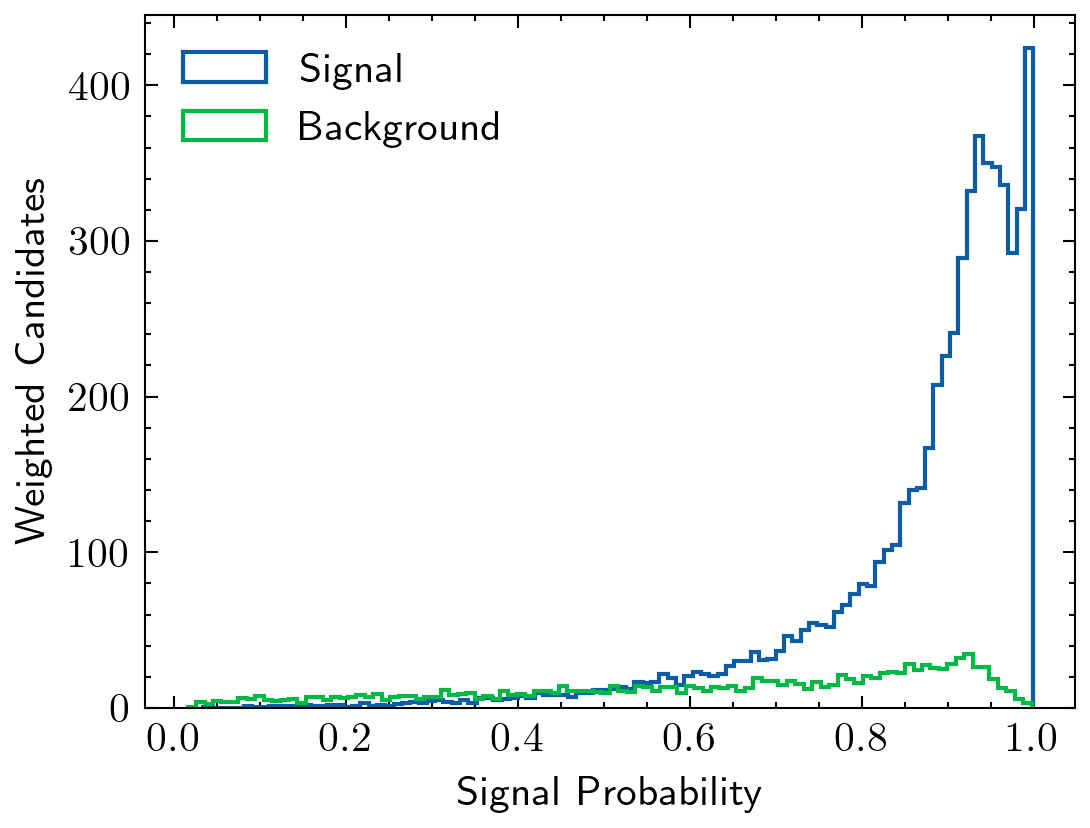

In [336]:
prediction = model.predict_proba(x_test)

# build lists of predicted probabilities with weights
sig_scores = []
sig_weights = []
bkg_scores = []
bkg_weights = []

for (p, cls, w) in zip(prediction, y_test, w_test):
    if cls == 1:
        sig_scores.append(p[1])
        sig_weights.append(w)
    else:
        bkg_scores.append(p[1])
        bkg_weights.append(w)

plt.figure(dpi=300)

plt.hist(sig_scores, bins=100, weights=sig_weights, label='Signal', alpha=1, histtype='step')
plt.hist(bkg_scores, bins=100, weights=bkg_weights, label='Background', alpha=1, histtype='step')

plt.xlabel('Signal Probability')
plt.ylabel('Weighted Candidates')
plt.legend()
plt.show()


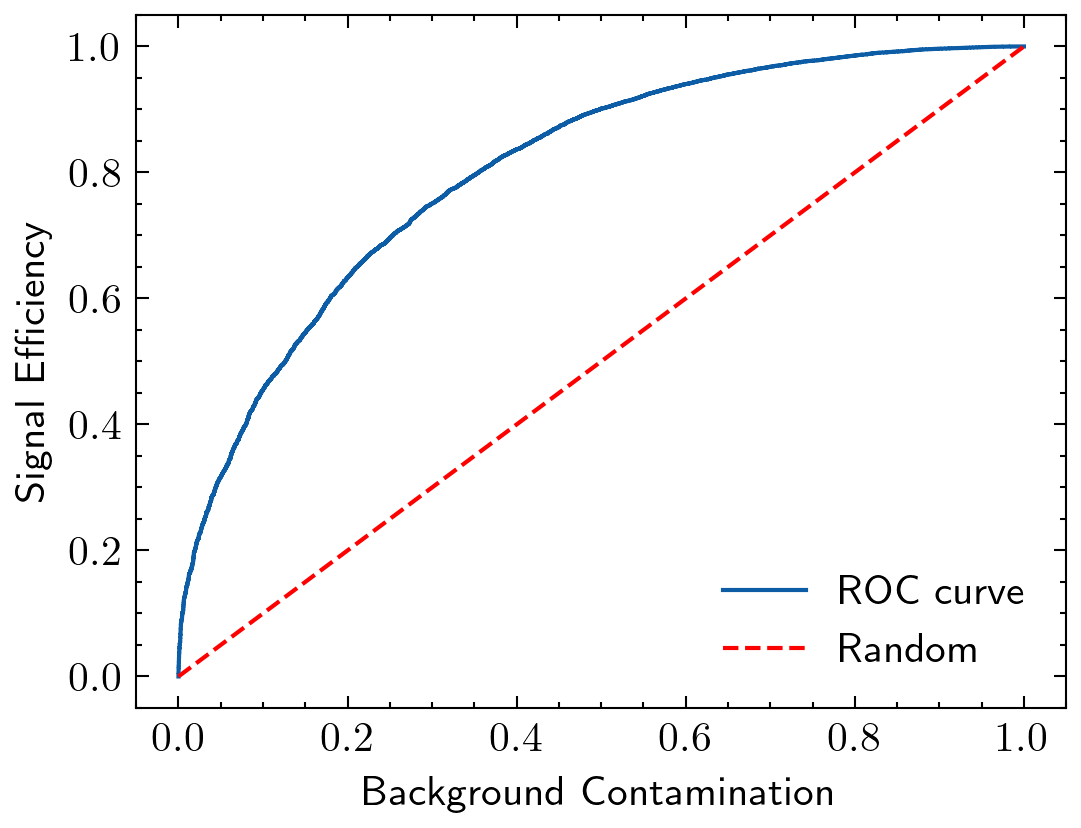

Area under curve 0.8050521056874738


In [337]:
#This clearly is now a very separating value to make a selection on.
#We can look at the performance of the algorithm in different ways.
#The next is the ROC curve, this stands for receiver operating characteristic.
#Essentially for each value of signal probability it shows the signal and
#background efficiencies, the further into the corner the better. This
#is why we chose the area under this curve as the figure of merit to train
#against. 0.5 is no better than a coin flip, 1 is perfect separation

from sklearn.metrics import roc_curve
background_accepted, signal_accepted, probabilities_tested = roc_curve(y_test, prediction[:,1])
plt.figure(dpi=300)
plt.plot(background_accepted, signal_accepted, label='ROC curve')
plt.plot([0,1], [0,1], color='red', linestyle='--', label = 'Random')
plt.xlabel('Background Contamination')
plt.ylabel('Signal Efficiency')
plt.legend()
plt.show()
print('Area under curve', np.trapz(signal_accepted, background_accepted))

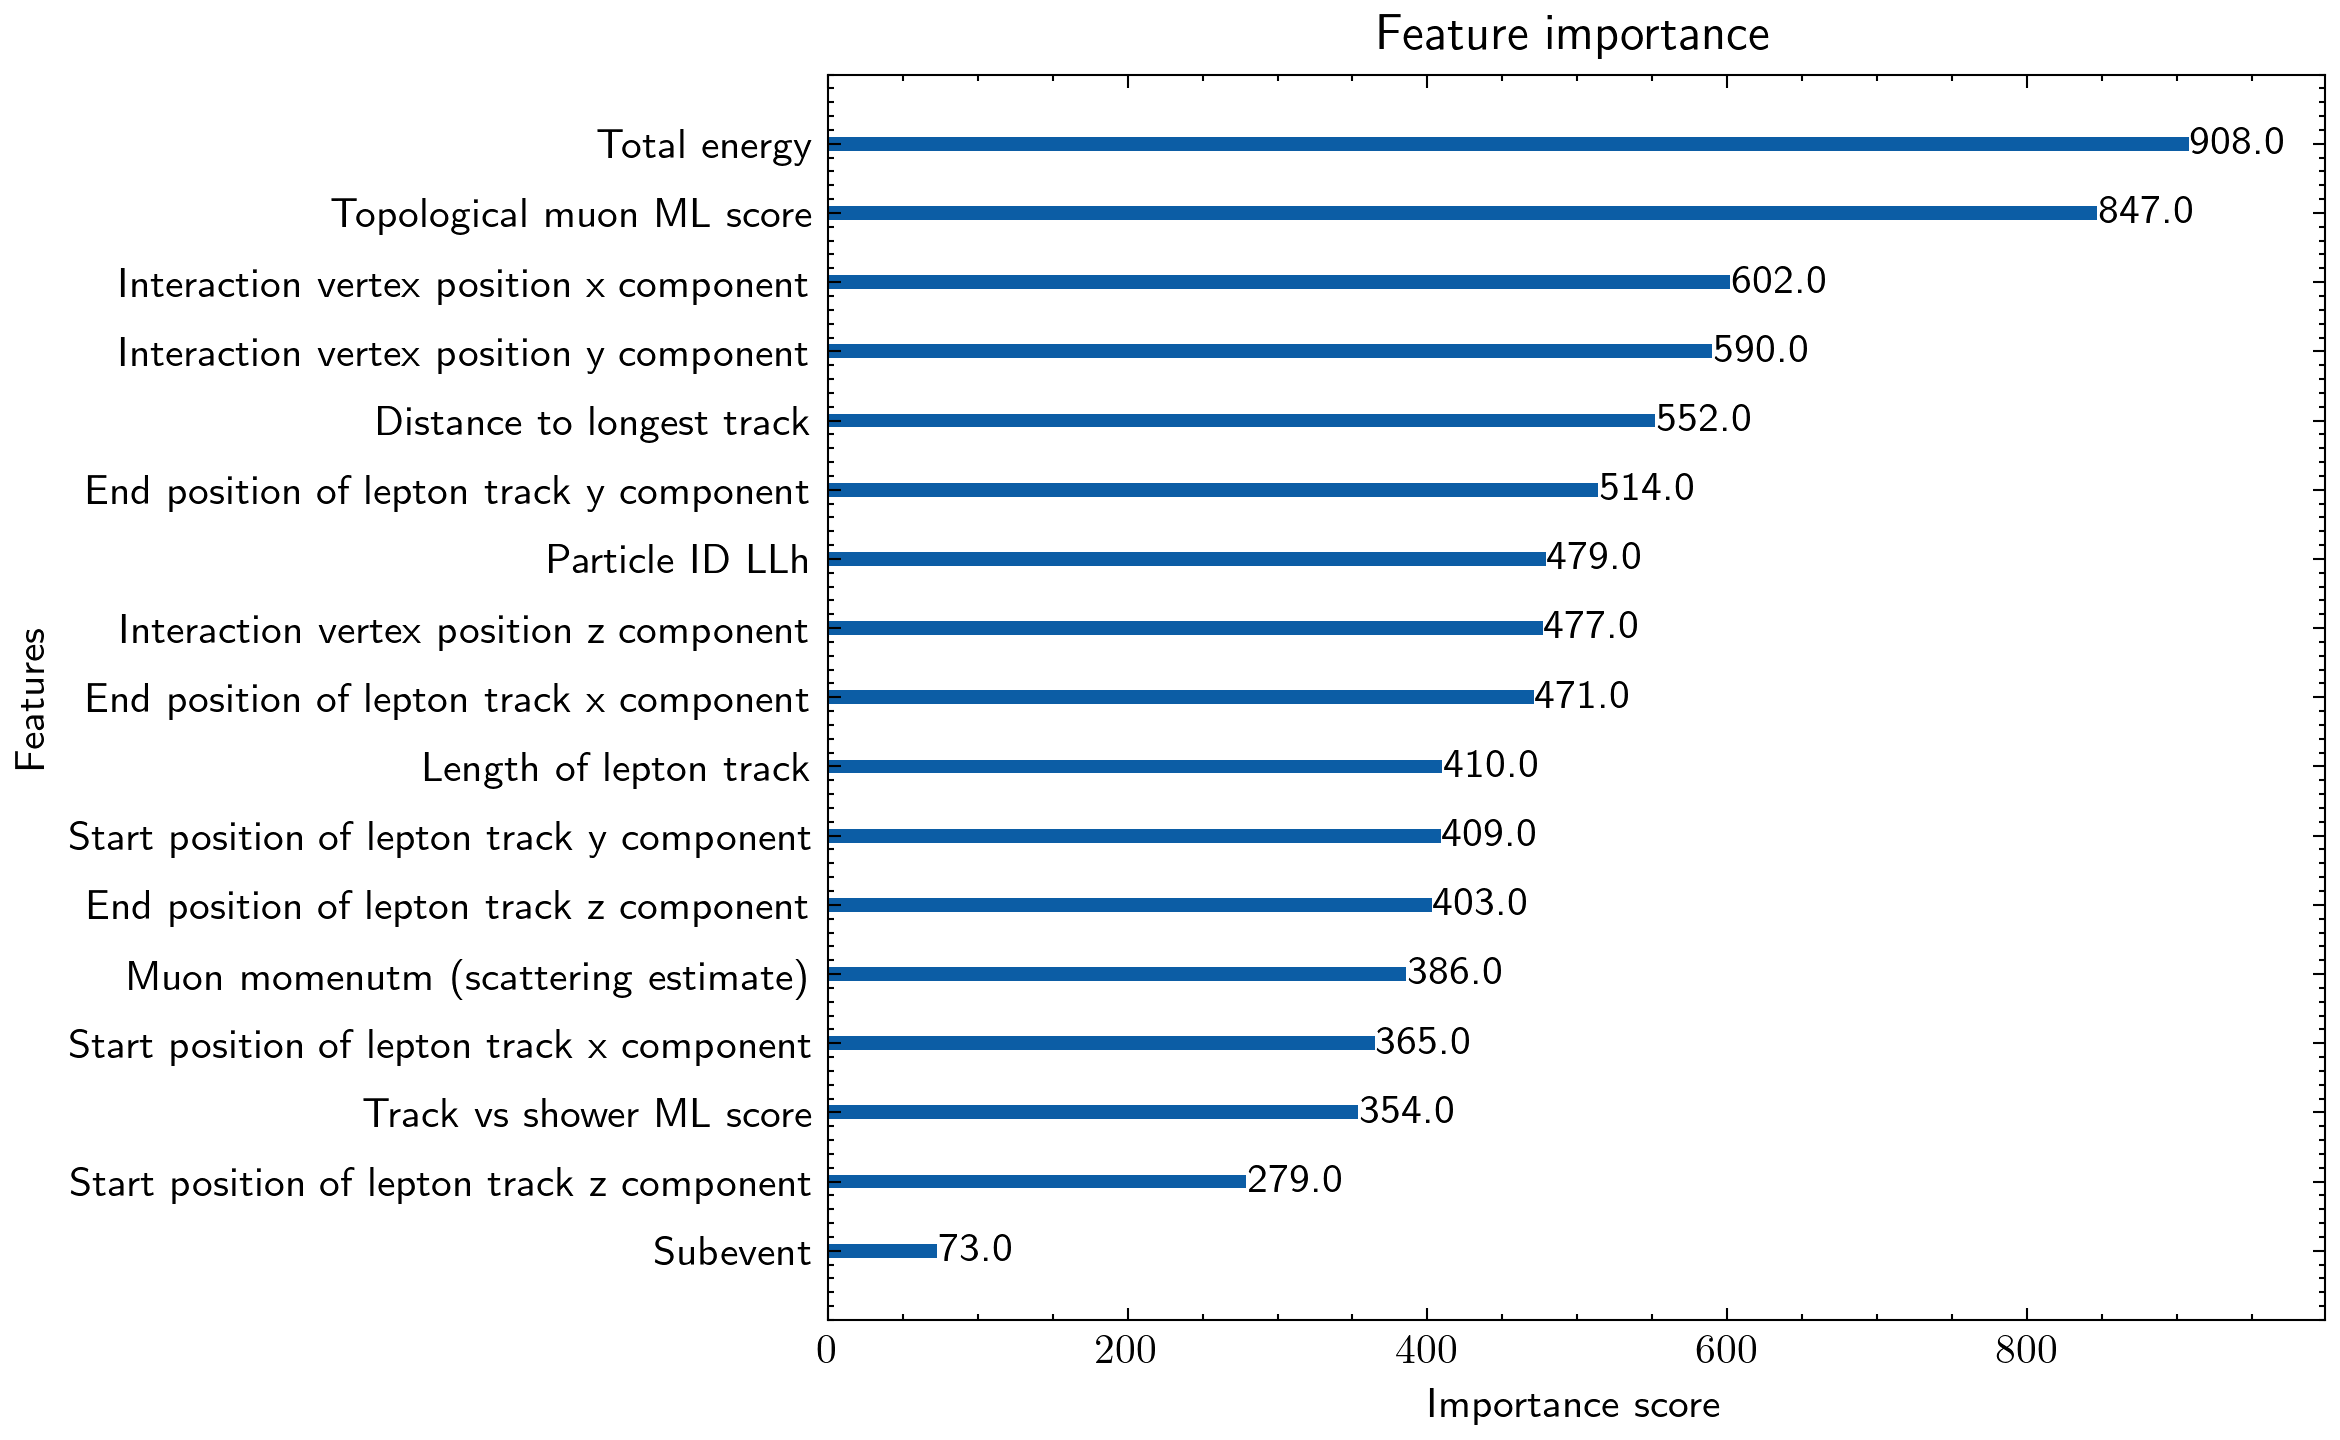

In [338]:
#Another useful diagnostic is to look at which of the variables are most useful
#in the clasificaton. Here it is academic, but it is important to think
#whether the relative importance makes sense. If not it could indicate
#something has gone wrong with the training

fig, ax = plt.subplots(figsize=(8,5), dpi=300)

xgboost.plot_importance(model, ax=ax, grid=False)

plt.tight_layout()
plt.show()


# Let's compare the reconstructed energy of the test data vs experiment

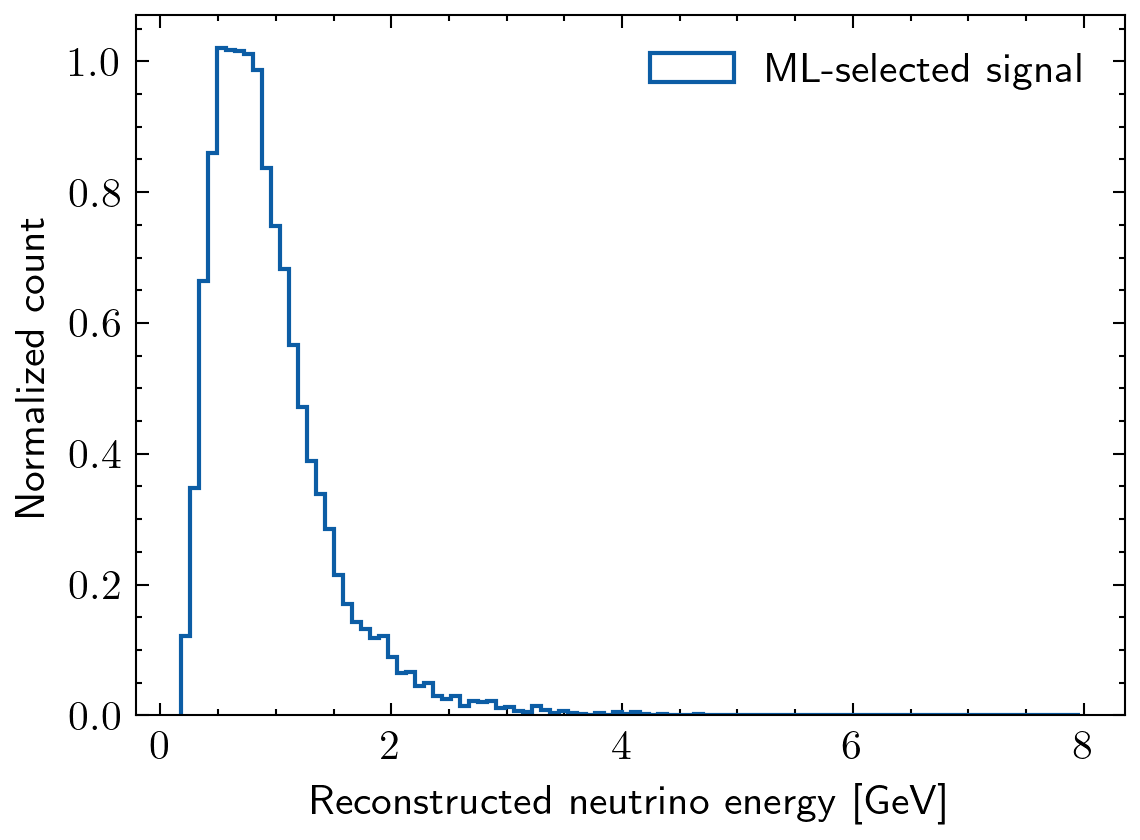

In [366]:
# model prediction on test features
prediction = model.predict_proba(x_test)
scores = prediction[:, 1]    # probability of being signal

# rebuild the real test data (physics variables, untouched)
sig_test = sig[nSignalTrain:].reset_index(drop=True)
bkg_test = bkg[nBackgroundTrain:].reset_index(drop=True)

data_test = pandas.concat([sig_test, bkg_test], axis=0, ignore_index=True)

# extract true physics variables and weights
energy_test  = data_test['Total energy'].to_numpy()
weight_test  = data_test['Simulation weight'].to_numpy()

# classifier threshold
threshold = 0.5

# events classified as signal by the model
energy_sig_like  = energy_test[scores > threshold]
weight_sig_like  = weight_test[scores > threshold]

# plot weighted histogram
plt.figure(dpi=300)
plt.hist(
    energy_sig_like,
    bins=100,
    weights=weight_sig_like,
    histtype='step',
    label='ML-selected signal',
    density = True
)

plt.xlabel('Reconstructed neutrino energy [GeV]')
plt.ylabel('Normalized count')
plt.legend()
plt.tight_layout()
plt.show()


# Apply selection criteria to actual data

In [351]:
with open('../MicroBooNE/Data.pkl', 'rb') as infile:
  data_exp = pickle.load(infile)

In [352]:
for variable_name in list(data_exp):
  print(variable_name)


Distance to closest cosmic ray track
Length of lepton track
Distance to longest track
Simulation category
Topological muon ML score
End position of lepton track z component
End position of lepton track y component
End position of lepton track x component
Track vs shower ML score
Particle ID LLh
Start position of lepton track z component
Start position of lepton track y component
Start position of lepton track x component
Interaction vertex position x component
Interaction vertex position y component
Interaction vertex position z component
Total energy
Subevent
Muon momenutm (length estimate)
Muon momenutm (scattering estimate)


Number of experimental events passing ML selection: 25868


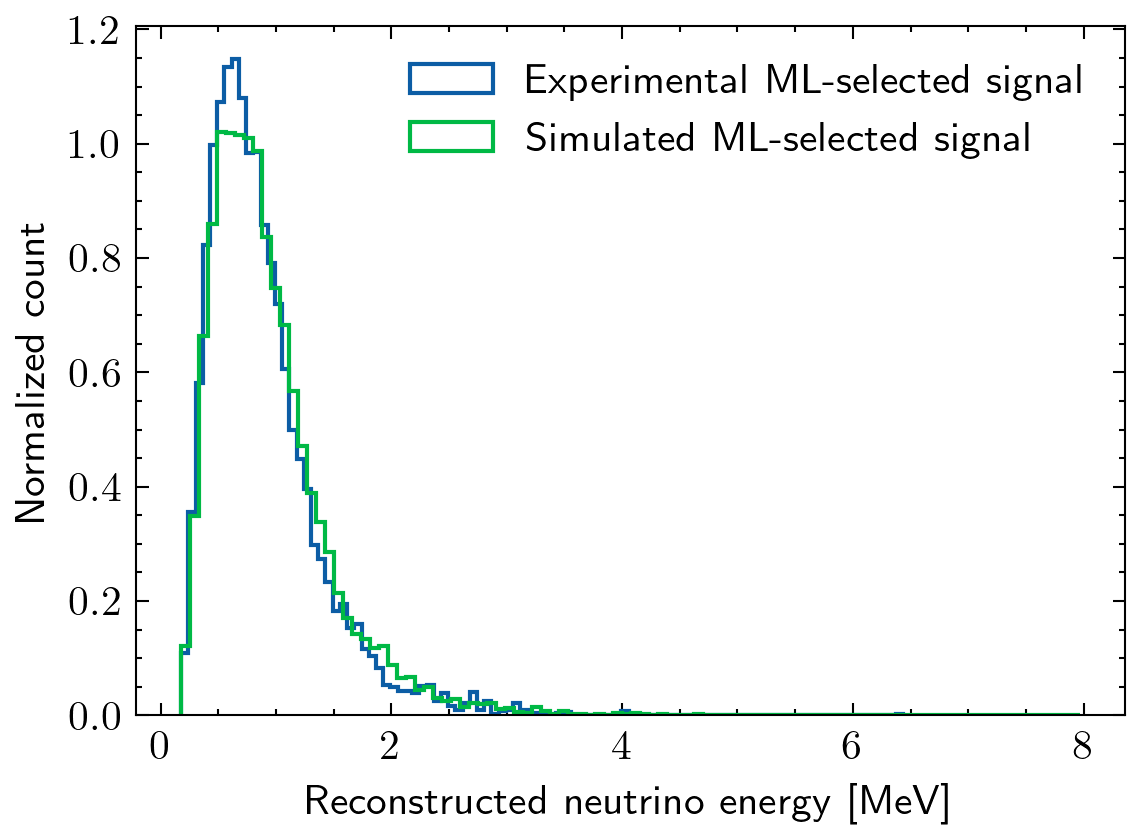

In [368]:
import pandas as pd 

# features used in the ML model
features = [
    'Topological muon ML score',
    'Length of lepton track',
    'Distance to longest track',
    'End position of lepton track z component',
    'End position of lepton track y component',
    'End position of lepton track x component',
    'Particle ID LLh',
    'Start position of lepton track z component',
    'Start position of lepton track y component',
    'Start position of lepton track x component',
    'Interaction vertex position x component',
    'Interaction vertex position y component',
    'Interaction vertex position z component',
    'Total energy',
    'Muon momenutm (length estimate)',
    'Muon momenutm (scattering estimate)',
    'Track vs shower ML score',
    'Subevent'
]

# load experimental dataset
with open('../MicroBooNE/Data.pkl', 'rb') as infile:
    data_exp = pickle.load(infile)

# make numeric
for col in features:
    data_exp[col] = pd.to_numeric(data_exp[col], errors='coerce')

# apply the experimental manual cut
energy_cut_value = 10       
manual_selection_exp = data_exp['Total energy'] < energy_cut_value

data_exp_sel = data_exp[manual_selection_exp].copy()

# build ML input matrix
x_exp = data_exp_sel[features]

# run the ML model
scores_exp = model.predict_proba(x_exp)[:, 1]

# apply the ML threshold (replace with your optimal threshold)
threshold = 0.5
signal_mask_exp = scores_exp > threshold

signal_events_exp = data_exp_sel[signal_mask_exp]

print("Number of experimental events passing ML selection:", len(signal_events_exp))

# example histogram
plt.figure(dpi=300)
plt.hist(
    signal_events_exp['Total energy'],
    bins=100,
    histtype='step',
    label='Experimental ML-selected signal',
    density=True
)

plt.hist(
    energy_sig_like,
    bins=100,
    weights=weight_sig_like,
    histtype='step',
    label='Simulated ML-selected signal',
    density = True
)

plt.legend()
plt.xlabel('Reconstructed neutrino energy [MeV]')
plt.ylabel('Normalized count')
plt.tight_layout()
plt.show()
